# Prototype: Alpha

| Properties      | Data    |
|---------------|-----------|
| *Labels* | `['BENIGN', 'DDoS']` |
| *Normalization* | `Min-Max` |
| *Sample Size* | `4000`|
| *Adversarial Attack* | `FGSM` |
| *Explanations* | `SHAP` |


---

In [77]:
# To import modules from the functions directory
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

## Data Preprocessing

In [78]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

encoding_type = 0 # binary encoding
norm_type = 0 # min-max normalization
label_names = ['BENIGN', 'DDoS'] # labels to include
sample_size = 2000 # sample size for each label -> 2 x sample_size = total samples

dataset = dp.build_dataset(label_names)

normalizer, zero_columns = dp.generate_normalizer(dataset, norm_type)

feature_df, label_df, used_indices = dp.preprocess_data(dataset, encoding_type, normalizer, zero_columns, sample_size, 42)
print(label_df.value_counts()) # -> will first show [0, 1] then [1, 0] if label number is equal

-- Building CICIDS2017 dataset --
--- Combining all CICIDS2017 files ---
Wednesday-workingHours.pcap_ISCX.csv
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Tuesday-WorkingHours.pcap_ISCX.csv
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Monday-WorkingHours.pcap_ISCX.csv
Friday-WorkingHours-Morning.pcap_ISCX.csv
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
--- Removing NaN and Infinity values ---
Removing 1358 Rows with NaN values
Removing 1509 Rows with Infinity values
--- Extracting labels ---
 Label
BENIGN    2271320
DDoS       128025
Name: count, dtype: int64
-- Generating normalizer --
--- Splitting labels and features ---
Zero Columns: [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
-- Preprocessing data --
--- Sampling balanced data ---
Sample to shape: (4000, 79)
--- Splittin

## Split Data

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3200, 70) (800, 70) (3200, 2) (800, 2)


## Create IDS

In [155]:
import functions.intrusion_detection_system as ids
import importlib
importlib.reload(ids)

ids_model = ids.build_intrusion_detection_system(X_train, y_train, X_test, y_test)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5276 - loss: 0.6719 - val_accuracy: 0.6875 - val_loss: 0.5860
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7404 - loss: 0.5478 - val_accuracy: 0.9922 - val_loss: 0.4473
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9796 - loss: 0.4052 - val_accuracy: 0.9844 - val_loss: 0.2844
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9819 - loss: 0.2471 - val_accuracy: 0.9859 - val_loss: 0.1417
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9770 - loss: 0.1333 - val_accuracy: 0.9844 - val_loss: 0.0683
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9801 - loss: 0.0742 - val_accuracy: 0.9906 - val_loss: 0.0518
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9810 - loss: 0.0596 - val_accuracy: 0.9844 - val_loss: 0.0431
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9829 - loss: 0.0590 - val_accuracy: 0.9891 - val_loss:

## Generate Attacks

In [81]:
import functions.attack_generator as ag
import importlib
importlib.reload(ag)

# fit art model with all features
all_features = dataset.drop(columns=[' Label'])
art_model = ag.convert_to_art_model(ids_model, all_features)

# import numpy as np
# target_label = np.zeros_like(y_train)
# target_label[:, 0] = 1 # desired predicted label = [1, 0] = BENIGN
# print(target_label[:3])

X_adv_fgsm = ag.generate_fgsm_attacks(art_model, X_train)
print(X_adv_fgsm.iloc[:, :3].head(2))

ag.evaluate_art_model(art_model, X_adv_fgsm, y_train)

Adversarial FGSM examples generated. Shape: (3200, 70)
   Destination Port  Flow Duration  Total Fwd Packets
0          0.101221        0.13225           0.100018
1          0.000000        0.00000           0.000000
Accuracy: 15.41%
              precision    recall  f1-score   support

      BENIGN       0.21      0.25      0.23      1578
      ATTACK       0.08      0.06      0.07      1622

   micro avg       0.15      0.15      0.15      3200
   macro avg       0.14      0.16      0.15      3200
weighted avg       0.14      0.15      0.15      3200
 samples avg       0.15      0.15      0.15      3200

Confusion Matrix: Positive == BENIGN
TN: 96, FP: 1526, FN: 1181, TP: 397


0.1540625

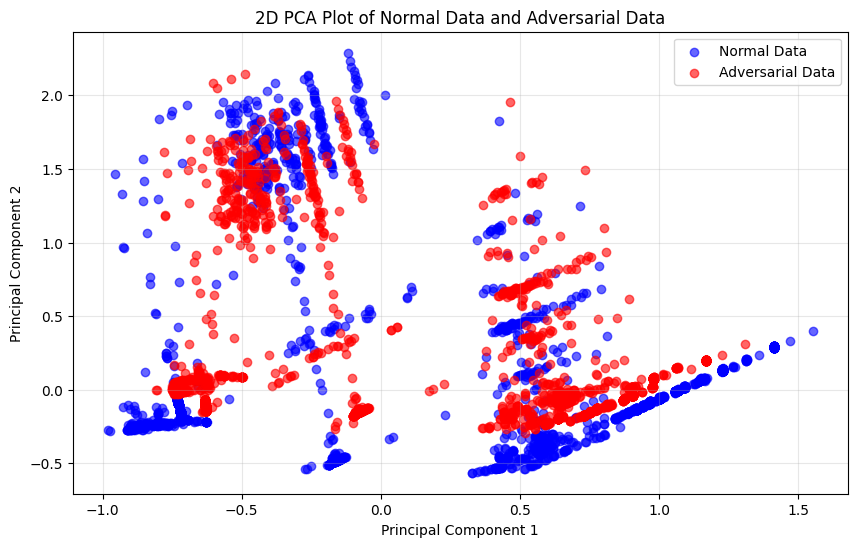

In [82]:
import functions.visualizer as visualizer
import importlib
importlib.reload(visualizer)

visualizer.visualize_data_distribution(X_train, 'Normal Data', X_adv_fgsm, 'Adversarial Data')

## Explainer

In [83]:
import functions.explainer as exp
import importlib
importlib.reload(exp)

explainer = exp.generate_shap_explainer(ids_model, X_train)

shap_values, shap_values_df = exp.generate_shap_values(explainer, X_train)
print(shap_values_df.shape)

shap_values_adv, shap_values_adv_df = exp.generate_shap_values(explainer, X_adv_fgsm)
print(shap_values_adv_df.shape)

PermutationExplainer explainer: 3201it [03:32, 14.36it/s]                          


(3200, 70)


PermutationExplainer explainer: 3201it [03:06, 16.27it/s]                          


(3200, 70)


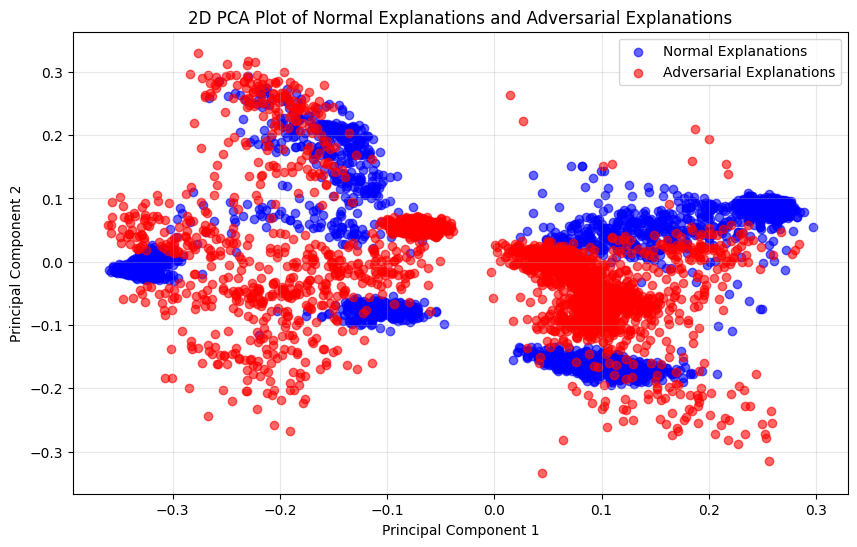

In [84]:
visualizer.visualize_data_distribution(shap_values_df, 'Normal Explanations', shap_values_adv_df, 'Adversarial Explanations')

## Detector

In [88]:
import functions.detector as det
import importlib
importlib.reload(det)
import numpy as np

# create dataframe
X, y = det.build_train_datasets(shap_values_df, shap_values_adv_df)
print(X.shape, y.shape)

# create normalizer
# normalizer = det.create_min_max_normalizer(X)
# print(np.max(normalizer.data_max_))
# print(np.min(normalizer.data_min_))

# TODO: how to normalize? min/max should be consistent for all datasets
# normalize features
# X = normalizer.transform(X)
# print(np.max(X))
# print(np.min(X))

# split data
X_train_det, X_test_det, y_train_det, y_test_det = train_test_split(X, y, test_size=0.1, random_state=1503)
print(X_train_det.shape, X_test_det.shape, y_train_det.shape, y_test_det.shape)

# build detector
detector = det.build_detector(X_train_det, y_train_det, X_test_det, y_test_det)


# normalizer_adv = det.create_min_max_normalizer(shap_values_adv_df)
# print(np.max(normalizer_adv.data_max_))
# print(np.min(normalizer_adv.data_min_))

# shap_values_normalized = det.normalize_shap_values(shap_values_df)
# print(shap_values_normalized.shape)
# print(np.max(shap_values_normalized))
# print(np.min(shap_values_normalized))

(6400, 70) (6400, 2)
(5760, 70) (640, 70) (5760, 2) (640, 2)
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6174 - loss: 0.6859 - val_accuracy: 0.8637 - val_loss: 0.6352
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8382 - loss: 0.6028 - val_accuracy: 0.9349 - val_loss: 0.4080
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9208 - loss: 0.3834 - val_accuracy: 0.9792 - val_loss: 0.1758
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9649 - loss: 0.2052 - val_accuracy: 0.9852 - val_loss: 0.0856
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9779 - loss: 0.1159 - val_accuracy: 0.9931 - val_loss: 0.0509
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9847 - loss: 0.0796 - val_accuracy: 0.9939 - val_loss: 0.0312
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9900 - loss: 0.0509 - val_accuracy: 0.9948 - val_loss: 0.0222
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

---
## Test Process

In [89]:
print(X_test.shape)

(800, 70)


### Generate Attacks

In [90]:
X_test_adv = ag.generate_fgsm_attacks(art_model, X_test)

Adversarial FGSM examples generated. Shape: (800, 70)


### Generate Explanations

In [91]:
X_test_adv_shap_values, X_test_adv_shap_values_df = exp.generate_shap_values(explainer, X_test_adv)
X_test_shap_values, X_test_shap_values_df = exp.generate_shap_values(explainer, X_test)

PermutationExplainer explainer: 801it [00:49, 12.96it/s]                         
PermutationExplainer explainer: 801it [00:50, 12.70it/s]                         


### Generate Datasets

In [92]:
X, y = det.build_train_datasets(X_test_shap_values_df, X_test_adv_shap_values_df)

### Preprocess Data

In [93]:
# print(np.max(X))
# print(np.min(X))
# X = normalizer.transform(X)
# print(np.max(X))
# print(np.min(X))

### Shuffle Data & Predict

In [94]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=187)

y_pred = detector.predict(X)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


### Evaluate

In [95]:
det.evaluate_model(y_pred, y)

Global Accuracy: 99.62%
              precision    recall  f1-score   support

      BENIGN       1.00      0.99      1.00       800
 ADVERSARIAL       1.00      1.00      1.00       800

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

True Negative Rate: 99.50%
False Positive Rate: 0.50%
True Positive Rate: 99.75%
False Negative Rate: 0.25%


---
## Additional Evaluation - New Samples

In [149]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

# exclude previously used samples
dataset_excluded = dataset.drop(index=used_indices)

X_eval, y_eval, _ = dp.preprocess_data(dataset_excluded, encoding_type, normalizer, zero_columns, sample_size=500, random_sample_state=17)
print(y_eval.value_counts())

-- Preprocessing data --
--- Sampling balanced data ---
Sample to shape: (1000, 79)
--- Splitting labels and features ---
--- Encoding labels as binary one-hot values ---
--- Normalizing features using MinMaxScaler ---
BENIGN  ATTACK
False   True      500
True    False     500
Name: count, dtype: int64


In [150]:
X_adv_fgsm_eval = ag.generate_fgsm_attacks(art_model, X_eval)
print(X_adv_fgsm.iloc[:, :3].head(2))

ag.evaluate_art_model(art_model, X_adv_fgsm_eval, y_eval)

Adversarial FGSM examples generated. Shape: (1000, 70)
   Destination Port  Flow Duration  Total Fwd Packets
0          0.101221        0.13225           0.100018
1          0.000000        0.00000           0.000000
Accuracy: 15.50%
              precision    recall  f1-score   support

      BENIGN       0.21      0.26      0.23       500
      ATTACK       0.07      0.05      0.06       500

   micro avg       0.15      0.15      0.15      1000
   macro avg       0.14      0.15      0.15      1000
weighted avg       0.14      0.15      0.15      1000
 samples avg       0.15      0.15      0.15      1000

Confusion Matrix: Positive == BENIGN
TN: 26, FP: 474, FN: 371, TP: 129


0.155

In [151]:
X_eval_adv_shap_values, X_eval_adv_shap_values_df = exp.generate_shap_values(explainer, X_adv_fgsm_eval)
X_eval_shap_values, X_eval_shap_values_df = exp.generate_shap_values(explainer, X_eval)

PermutationExplainer explainer: 1001it [01:01, 13.53it/s]                         
PermutationExplainer explainer: 1001it [01:04, 13.26it/s]                          


In [152]:
X_eval_detector, y_eval_detector = det.build_train_datasets(X_eval_shap_values_df, X_eval_adv_shap_values_df)
print(X_eval_detector.shape, y_eval_detector.shape)

(2000, 70) (2000, 2)


In [153]:
from sklearn.utils import shuffle

X_eval_detector, y_eval_detector = shuffle(X_eval_detector, y_eval_detector, random_state=187)

y_pred_eval_detector = detector.predict(X_eval_detector)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [154]:
det.evaluate_model(y_pred_eval_detector, y_eval_detector)

Global Accuracy: 99.85%
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00      1000
 ADVERSARIAL       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

True Negative Rate: 99.80%
False Positive Rate: 0.20%
True Positive Rate: 99.90%
False Negative Rate: 0.10%


---
## Normal vs. Adversarial Explanations for *BENIGN* Traffic

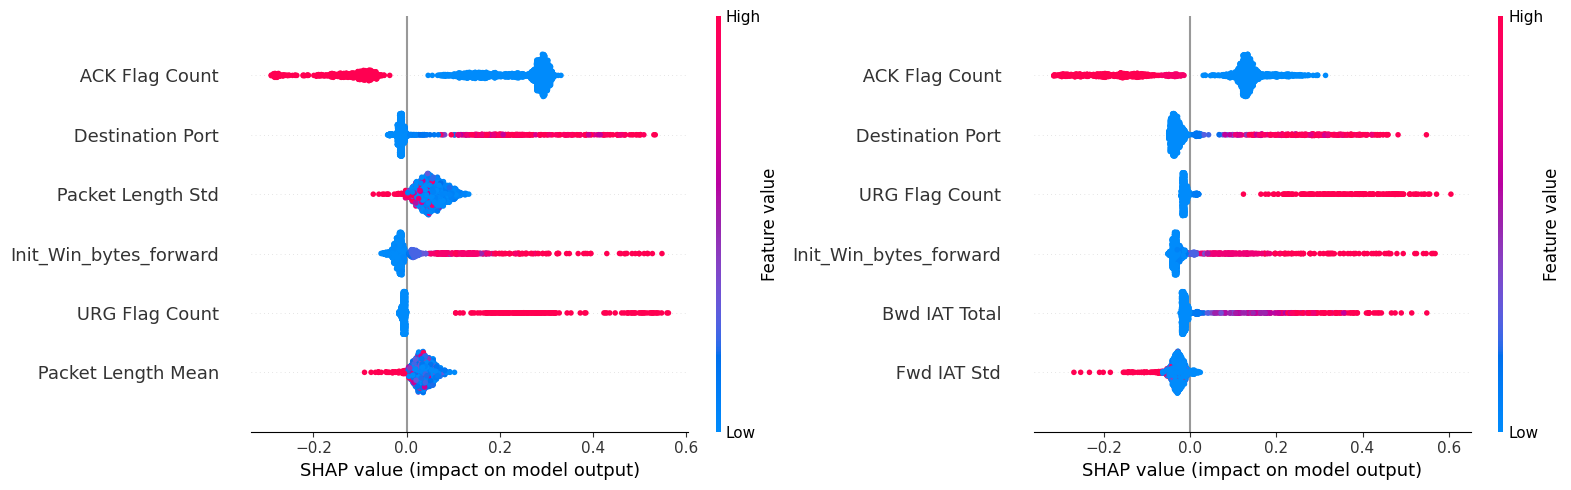

In [148]:
# find benign samples
benign_samples = np.where(y_train['BENIGN'] == 1)
exp.plot_shap_summary_comparison(shap_values, X_train, shap_values_adv, X_adv_fgsm, 6, target_indices=benign_samples)